# S&P500 prediction using WaveNet

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.custom_metrics as metrics
import deep4cast.topologies as topologies
from deep4cast import custom_losses

%matplotlib inline

## Data preparation

The data consists of almost a century long daily history of the S&P500 closing prices. Our goal is to forecast it. Here, we choose to train our model on the first 75% of the data and evaluate on the last 25%.

In [8]:
df = pd.read_table('sp500.csv', sep=',')
df = df.replace(-1,np.nan)
df = df.replace("#DIV/0!",np.nan)
df = df.dropna()
df.Date = pd.to_datetime(df.Date)
df['Closing Value'] = pd.to_numeric(df['Closing Value'])
df.Return = pd.to_numeric(df.Return)
df.set_index('Date', inplace=True)

time = df.index
data = df['Return'].values
data = np.expand_dims(data,0)
data = np.expand_dims(data,2)

train_length = int(data.shape[1]*0.75)
train_data = data[:,:train_length,:]

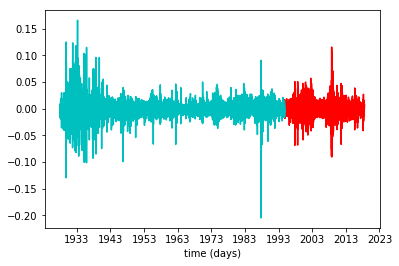

In [9]:
# Let plot the data
plt.plot(time[train_length:], data[0,train_length:,0], 'r-')
plt.plot(time[:train_length], data[0,:train_length,0], 'c-')
plt.xlabel('time (days)')
plt.show()

## Modeling

Here, we use a WaveNet-like architecture as neural network model.

In [49]:
topology = topologies.WaveNet(filters=32, num_layers=5)

In [50]:
lag = 56
horizon=1
forecaster = Forecaster(
    topology,
    lag=lag,  # This is the number of time steps used to predict the future for each data point
    horizon=horizon,  # This is how many time steps into the future we want to produce
    loss=custom_losses.heteroscedastic_t(nu=5, n_dim=1), 
    lr=0.001  # This is the learning rate for the optimizer
)

In [51]:
forecaster.fit(train_data, verbose=1)  # patience is the number of epochs to wait until early stopping is executed

Train on 16003 samples, validate on 1784 samples
Epoch 1/100
16003/16003 [==============================] - 12s 760us/step - loss: 1.0208 - val_loss: 0.1655
Epoch 2/100
16003/16003 [==============================] - 10s 655us/step - loss: 0.3368 - val_loss: 0.1250
Epoch 3/100
16003/16003 [==============================] - 10s 635us/step - loss: 0.2696 - val_loss: 0.0662
Epoch 4/100
16003/16003 [==============================] - 10s 653us/step - loss: 0.2340 - val_loss: 0.0519
Epoch 5/100
16003/16003 [==============================] - 10s 641us/step - loss: 0.2123 - val_loss: 0.0495
Epoch 6/100
16003/16003 [==============================] - 10s 628us/step - loss: 0.1931 - val_loss: 0.0381
Epoch 7/100
16003/16003 [==============================] - 10s 642us/step - loss: 0.1813 - val_loss: 0.0306
Epoch 8/100
16003/16003 [==============================] - 10s 638us/step - loss: 0.1747 - val_loss: 0.0462
Epoch 9/100
16003/16003 [==============================] - 10s 629us/step - loss: 0.164

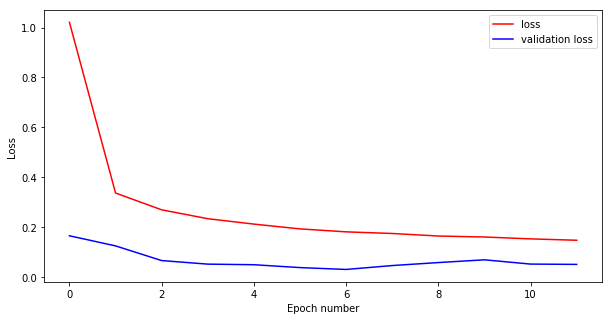

In [52]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'blue') 
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(['loss', 'validation loss'])

In the next step we make a prediction for the entire test set in horizon-sized steps.

In [103]:
test_data = data[:,train_length-lag:,:]
X, __ = forecaster._sequentialize(test_data)
X = X[:-1]
n_samples=20

samples = []
for i, step in enumerate(X):
    if i%1000==0:
        print("Pecent completed: {} %".format(round(i/len(X), 2)))
    step = np.expand_dims(step, 0)
    prediction = forecaster.predict(step, n_samples=n_samples)
    samples.append(prediction['samples'])
    
samples = np.concatenate(samples, axis=2)
samples = np.squeeze(samples)
data_truth = np.squeeze(data[:,train_length:,:])[:samples.shape[1]]
test_time = time[train_length:][:samples.shape[1]]

Pecent completed: 0.0 %
Pecent completed: 0.17 %
Pecent completed: 0.34 %
Pecent completed: 0.5 %
Pecent completed: 0.67 %
Pecent completed: 0.84 %


Now let's visualize the test set returns and sampled predictions.

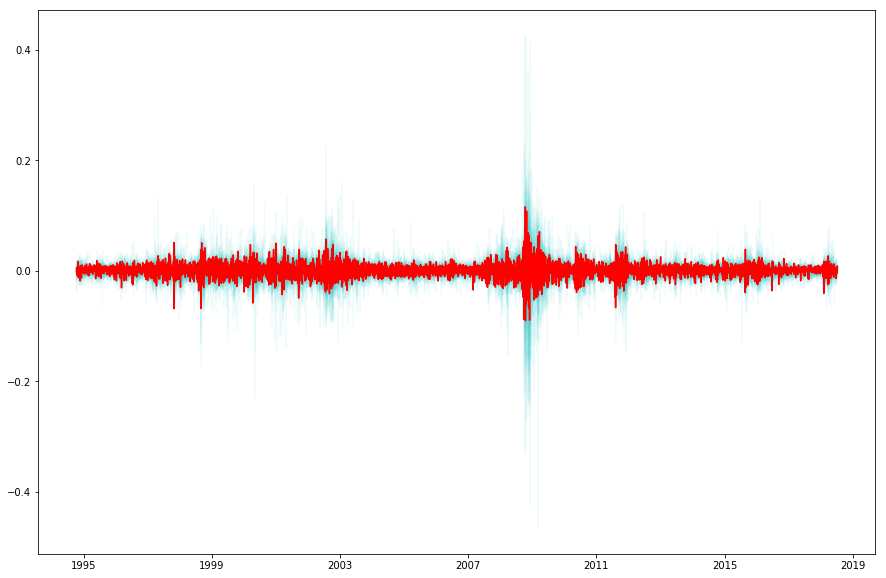

In [104]:
plt.figure(figsize=(15,10))
for sample in samples:
    plt.plot(test_time, sample, 'c', alpha=0.05)
plt.plot(test_time, actual_data, 'r-')

Text(0,0.5,'Prediction quantile')

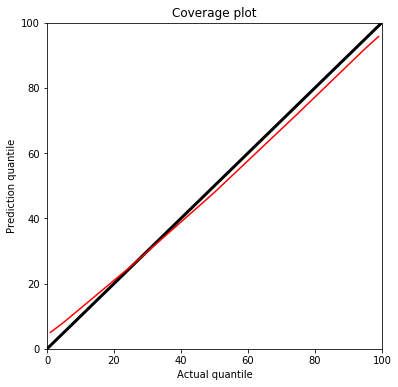

In [105]:
# Calculate coverage and plot percentile coverage
percentiles = [1, 5, 25, 50, 75, 95, 99]

plt.figure(figsize=(6, 6))
plt.plot([0] + percentiles + [100], [0] + percentiles + [100], 'k-', linewidth=3)

pred_perc = []
for percentile in percentiles:
    pred_perc.append(metrics.coverage(np.percentile(samples, percentile, axis=0), data_truth))
plt.plot(percentiles, pred_perc, 'r-')
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.title('Coverage plot')
plt.xlabel('Actual quantile')
plt.ylabel('Prediction quantile')